In [196]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [197]:
#@title Define Hyperparameters

input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 10 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-2 # size of step 

In [198]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [199]:
#@title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [200]:
from torch.autograd import Function

class PhotonCountingP(nn.Module):
    """ The probability of 1 photon in photon counting 
        (also the expectation value) with mean flux x """
    def __init__(self):
        super(PhotonCountingP, self).__init__()

    def forward(self, x):
        return 1.-torch.exp(torch.abs(x)*-1.)
    
class BernoulliFunctionST(Function):
    """ The 'Straight Through' stochastic Bernoulli activation"""
    @staticmethod
    def forward(ctx, input):

        return torch.bernoulli(input)

    @staticmethod
    def backward(ctx, grad_output):

        return grad_output

class PoissonFunctionST(Function):
    """ The 'Straight Through' stochastic Poisson activation"""
    @staticmethod
    def forward(ctx, input):

        return torch.poisson(input)

    @staticmethod
    def backward(ctx, grad_output):

        return grad_output
    
PoissonST = PoissonFunctionST.apply    
BernoulliST = BernoulliFunctionST.apply 

In [201]:
#@title Define model class

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, scale = 1, slope = 1, repeat = 5):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.act = PhotonCountingP()
    self.sampler = BernoulliST
    self.scale = scale
    self.slope = slope
    self.repeat = repeat
  
  def forward(self,x):
    out = self.fc1(x)
    # out = self.relu(out)
    probs = self.act(self.slope * out)
    out = self.sampler(probs.unsqueeze(0).repeat((self.repeat,)+(1,)*len(probs.shape))).mean(axis=0)*torch.sign(out)
    out = self.fc2(out)
    return out

In [202]:
#@title Build the model

# if torch.cuda.is_available():
#   net.cuda()

In [203]:
#@title Training the model


def runModel(count):
  accuracies = []
  # photonCounts = []
  hiddenLayer = []

  # finalaccuracies = []
  # finalCounts = []

  for j in range(8):
    hidden_size = (j+1)*50
    # count = j + 1
    net = Net(input_size, hidden_size, num_classes, repeat= count)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam( net.parameters(), lr=lr)
    max = 0
    for epoch in range(num_epochs):
      for i ,(images,labels) in enumerate(train_gen):
        images = Variable(images.view(-1,28*28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
          print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))
        # if (i+1) % 100 == 0:
        #   print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Accuracy: %.1f'
        #             %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item(), accuracy))
      correct = 0
      total = 0
      for images,labels in test_gen:
        images = Variable(images.view(-1,28*28))
        labels = labels
        
        output = net(images)
        _, predicted = torch.max(output,1)
        correct += (predicted == labels).sum()
        total += labels.size(0)

      accuracy = (100*correct)/(total+1)
      if max < accuracy.item():
        max = accuracy.item()

    accuracies.append(max)
    hiddenLayer.append(hidden_size)
        # photonCounts.append(count)
    # finalaccuracies.append(accuracy)
    # finalCounts.append(count)
  return accuracies, hiddenLayer
        

In [204]:

# for i in range(len(accuracies)):
#     accuracies[i] = accuracies[i].item()

# for i in range(len(finalaccuracies)):
#     finalaccuracies[i] = finalaccuracies[i].item()

In [205]:
#@title Evaluating the accuracy of the model

# correct = 0
# total = 0
# for images,labels in test_gen:
#   images = Variable(images.view(-1,28*28))
#   labels = labels
  
#   output = net(images)
#   _, predicted = torch.max(output,1)
#   correct += (predicted == labels).sum()
#   total += labels.size(0)

# print('Accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

In [206]:
# import matplotlib.pyplot as plt
# print(photonCounts)
# print(accuracies)
# plt.plot(photonCounts, accuracies, 'o')
# plt.plot(finalCounts, finalaccuracies)
# plt.xlabel('Number of shots')
# plt.ylabel('accuracy')
# plt.title('Shot number vs. Accuracy after 10 epochs')
# plt.show()

Epoch [1/10], Step [100/600], Loss: 0.3716
Epoch [1/10], Step [200/600], Loss: 0.2986
Epoch [1/10], Step [300/600], Loss: 0.2162
Epoch [1/10], Step [400/600], Loss: 0.1736
Epoch [1/10], Step [500/600], Loss: 0.3243
Epoch [1/10], Step [600/600], Loss: 0.2876
Epoch [2/10], Step [100/600], Loss: 0.1715
Epoch [2/10], Step [200/600], Loss: 0.1475
Epoch [2/10], Step [300/600], Loss: 0.1185
Epoch [2/10], Step [400/600], Loss: 0.2126
Epoch [2/10], Step [500/600], Loss: 0.3330
Epoch [2/10], Step [600/600], Loss: 0.2083
Epoch [3/10], Step [100/600], Loss: 0.1597
Epoch [3/10], Step [200/600], Loss: 0.1027
Epoch [3/10], Step [300/600], Loss: 0.1264
Epoch [3/10], Step [400/600], Loss: 0.0461
Epoch [3/10], Step [500/600], Loss: 0.1896
Epoch [3/10], Step [600/600], Loss: 0.1643
Epoch [4/10], Step [100/600], Loss: 0.1706
Epoch [4/10], Step [200/600], Loss: 0.1443
Epoch [4/10], Step [300/600], Loss: 0.0793
Epoch [4/10], Step [400/600], Loss: 0.0541
Epoch [4/10], Step [500/600], Loss: 0.1972
Epoch [4/10

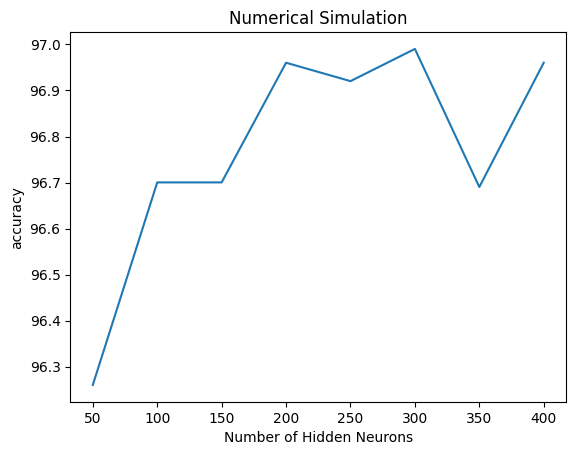

In [207]:
import matplotlib.pyplot as plt
accuracies1, size1 = runModel(1)
plt.plot(size1, accuracies1)
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('accuracy')
plt.title('Numerical Simulation')
plt.show()

In [208]:
# print(accuracies1)
# size1 = []
# for i in range(10):
#     size1.append(50)
# for i in range(10):
#     size1.append(100)
# for i in range(10):
#     size1.append(150)
# for i in range(10):
#     size1.append(200)
# for i in range(10):
#     size1.append(250)
# for i in range(10):
#     size1.append(300)
# for i in range(10):
#     size1.append(350)
# for i in range(10):
#     size1.append(400)

# plt.plot(size1, accuracies1)
# plt.xlabel('Number of Hidden Neurons')
# plt.ylabel('accuracy')
# plt.title('Numerical Simulation')
# plt.show()
